In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')

import sys

In [4]:
"""
u_t + c u_x = 0 on [a,b]
with u(b) = u(a)
"""
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

def gaussian(x):
    u = sp.exp(-10 * (x - 0.25)**2)
    return u


def step(x):
    u = np.zeros(x.shape)
    for j in range(len(x)):
        if (x[j] >= 0.6) and (x[j] <= 0.8):
            u[j] = 1.0

    return u


def progress(count, total, status=''):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * count / float(total), 1)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)

    sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', status))
    sys.stdout.flush()
    
    
def minmod(a, b):
    c = 0 * a
    for i in range(len(a)):
        if a[i] * b[i] > 0:
            if abs(a[i]) <= abs(b[i]):
                c[i] = a[i]
            else:
                c[i] = b[i]
        else:
            c[i] = 0.0
    return c


def maxmod(a, b):
    c = 0 * a
    for i in range(len(a)):
        if a[i] * b[i] > 0:
            if abs(a[i]) >= abs(b[i]):
                c[i] = a[i]
            else:
                c[i] = b[i]
        else:
            c[i] = 0.0
    return c


def calctv(u):
    """assumes periodic"""
    return np.abs(u[1:] - u[:-1]).sum() + abs(u[0] - u[-1])

0.0625
[========================================================----] 94.1% ...
n = 17, h = 0.0588235, e = 0.00233306
0.03125
[==========================================================--] 97.1% ...
n = 33, h = 0.030303, e = 0.000604246
0.015625
[===========================================================-] 98.5% ...
n = 65, h = 0.0153846, e = 0.000155617
0.0078125
[============================================================] 99.3% ...
n = 129, h = 0.00775194, e = 3.93537e-05
0.00390625
[============================================================] 99.6% ...
n = 257, h = 0.00389105, e = 9.94273e-06


order = 1.96259


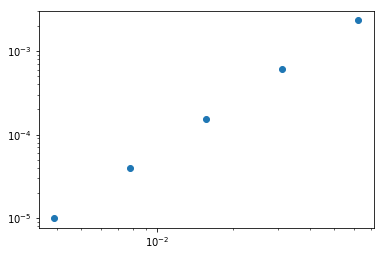

In [6]:
T = 1.0  # approximately

method= 'Fromm'
plotit = False
g = lambda x: np.sin(2 * np.pi * x)
#g = gaussian
#g = step

if plotit:
    dxs = 1.0 / np.array([64])
else:
    dxs = 1.0 / np.array([16, 32, 64, 128, 256])

errs = []

for dx in dxs:
    print(dx)
    lmbda = 0.95

    nx = int(1.0 / dx) + 1
    
    x = np.linspace(0, 1, nx, endpoint=False)
    dx = x[1] - x[0]

    dt = dx * lmbda
    nt = int(T/dt)

    J = np.arange(0, nx)  # all vertices
    Jm1 = np.roll(J, 1)
    Jp1 = np.roll(J, -1)

    u = g(x)
    tstep = np.arange(nt)
    tv = np.zeros(nt)
    tv[0] = calctv(u)
    
    if plotit:
        fig = plt.figure(figsize=(10, 5))
        
        ax = fig.add_subplot(122)
        ax.set_title('u vs x')
        line, = ax.plot(x, u, lw=3, clip_on=False)
        
        ax2 = fig.add_subplot(121)
        ax2.set_title('TV')
        line2, = ax2.plot(tstep, tv, 'o', clip_on=False)
        
        plt.close()

    def init():
        line.set_data([], [])
        line2.set_data([], [])
        return (line,line2)

    def timestepper(n):
        progress(n, nt)

        if method == 'constant':
            sig = 0 * u
        elif method == 'LaxW':
            sig = (u[Jp1] - u[J]) / dx
        elif method == 'BW':
            sig = (u[J] - u[Jm1]) / dx
        elif method == 'Fromm':
            sig = (u[Jp1] - u[Jm1]) / (2.0 * dx)
        elif method == 'minmod':
            sigm = (u[J] - u[Jm1]) / dx
            sigp = (u[Jp1] - u[J]) / dx
            sig = minmod(sigm, sigp)
        elif method == 'superbee':
            sigm = (u[J] - u[Jm1]) / dx
            sigp = (u[Jp1] - u[J]) / dx

            sig1 = minmod(sigm, 2 * sigp)
            sig2 = minmod(2 * sigm, sigp)
            sig = maxmod(sig1, sig2)


        u[J] = u[J] - (dt / dx) * (u[J] - u[Jm1])\
                    - (dt / (2.0 * dx)) * (dx - dt) * (sig[J] - sig[Jm1])

        tv[n] = calctv(u)
        
        if plotit:
            ax2.set_ylim([0, tv.max()])
            line.set_data(x, u)
            line2.set_data(tstep[:n], tv[:n])
            return (line,line2)
        else:
            return u

    if plotit:
        anim = animation.FuncAnimation(fig, timestepper, init_func=init, frames=nt, interval=50, blit=True)
    else:
        for n in range(nt):
            u = timestepper(n)
        l2error = np.sqrt(dx * np.sum( (u - g((x - nt * dt) % 1.0))**2 ))
        errs.append(l2error)
        print("\nn = %d, h = %g, e = %g" % (nx, dx, l2error))
        
if plotit:
    anim
else:
    plt.loglog(dxs, errs, 'o')
    order = np.polyfit(np.log10(dxs[:-1]), np.log10(errs[:-1]), deg=1)[0]
    print('\n\norder = %g' % order)

In [6]:
anim